# Metropolis

We have seen the Metropolis algorithm for hard spheres. It is a
particularly simple (but very powerful) example of this algorithm, so we didn't
need to explain several details. In this notebook we will apply the Metropolis
algorithm to explore phase transition in magnetic systems, using the Ising
model. 

## Basics: 

The basic idea of Monte Carlo's algorithms is to use
random variables to simulate stochastic problems. The simplest possibility is to
use a uniform random variable. Then, in our system, with many particles, and in
one of the possible states call $i$, we choose randomly another state of the
system call $j$. Then we calculate the transition probability $p_{i,j}$ from
state $i$ to state $j$. Then we generate a random number $x$ with a uniform
distribution between 0 and one (simply rand()). If $x<p_{i,j}$, then we change
the system to the new state, otherwise we stay in the original state. We repeat
this steps until we reach an equilibrium state. 

To calculate the transition
probability, we can use the Boltzmann distribution. After a little work on the
algebra, we obtain $p_{i,j} = exp((H_i -H_j)/KT)$. We can, of course, change
randomly to any possible state, but the fastest way is to modify the energy of
only one particle and their neighbors.

[1] Explain the metrópolis algorithm in
the Ising model. e.i. Do a list of the
steps. Yo will do on the whiteboard

[2]
One of the necessary steps in the algorithm is to know the neighbors. Then,
do a
function to produce a list of neighbors if you give the long and high of
the
system. Do it for square and hexagonal lattices. Use periodic boundary
conditions.

[3] Do a function to calculate the transition probability. It is
inefficient to
calculate $H_i$ and $H_j$ for the Ising model. What can you do to
calculate the
probability it efficiently?

[4] Next step is to do a function
depending on the temperature, Hamiltonian,
list of neighbors, magnetic field,
and may be other variables, that develop the
Metropolis algorithm for $n$ steps.
Do this function.

[5] Now measure the magnetization of the system (in the
square and hexagonal
lattice), as a function of the number of steps for
different temperatures (for
example, KT = 0.0001, KT = 2.2 and KT = 10). Do a
plot of it.

[6] When you can say that the system is in equilibrium?

[7] We
will call "thermalization steps" to those steps needed to reach the
equilibrium,
and Monte Carlo steps any step. Once you reach the equilibrium, you
will still
have fluctuations. We can reduce these fluctuations by doing an
average over
different Monte Carlo steps after the thermalization steps. Do a
function that
obtains this average for $n$ Monte Carlo steps.

[8] We are interested to check
the behavior of the Magnetization as a function
of temperature or the magnetic
field. Do a function that uses the Metropolis
algorithm to calculate the
Magnetization for several temperatures from $T_a$ to
$T_b$ with steps of size
$\Delta T$, doing an average over $n$ Monte Carlo steps
after the thermalization
steps. ¿Which initial state we should take for each
temperature or magnetic
field?

Typically after doing this average, we still have some fluctuations, and
as we
are not really in an equilibrium state, the average is not good enough, so
we do
another average over different systems. We will jump this step, but it is
good
to keep in mind. 

[9] With this simple model and algorithm, what else you
can
calculate? Can you calculate $C_h$, how do you do? Do it if possible.

[10]
Play with the values of J, and B in the Ising Model. If J is negative, what
kind
of system represent? 

[11] what happens for low temperatures when J is
negative
and you use hexagonal lattices? do a plot of the system in equilibrium.
What is
the big difference between the hexagonal and square lattice in this
case?

In [1]:
extension(path::String) = match(r"\.[A-Za-z0-9]+$", path).match
    
struct Gnuplot
    filename::String
    ext::String
    f::Pipe
    p::Base.Process
    function Gnuplot(filename::String)
        f,p = open(`gnuplot`,"w")
        ext = extension(filename)
        if ext == ".svg"
            write(f,"set terminal epslatex standalone\\
                    color background 'white' lw 3 font ',12'\\
                    header '\\usepackage[utf8]{inputenc} \\usepackage{amsmath}';
                    set output 'gptemp.tex'; set colorsequence podo;")
        elseif ext == ".png"
            write(f,"set terminal png;
                    set output '$filename';
                    set colorsequence podo;")
        elseif ext == ".gif"
            write(f,"set terminal gif animate delay 100;
                    set output '$filename';
                    set colorsequence podo;")
        end
        return new(filename,ext,f,p)
    end
end
function plot(gp::Gnuplot)
    close(gp.f)
    wait(gp.p.closenotify)
    if gp.ext == ".svg"
        run(pipeline(`pdflatex gptemp.tex`, stdout=DevNull))
        run(`pdf2svg gptemp.pdf $(gp.filename)`)
        run(`find -x . -name gptemp\* -delete`)
        display("image/svg+xml",readstring("./$(gp.filename)"))
    elseif gp.ext == ".png"
        display("image/png",read("./$(gp.filename)"))
    elseif gp.ext == ".gif"
        display("image/gif",read("./$(gp.filename)"))          
    end
end

plot (generic function with 1 method)

In [2]:
mutable struct Lattice
    spins::Vector{Int}
    neighbours::Vector{Vector{Int}}
    M::Float64
    H::Float64
end

In [3]:
periodic(x,n) = mod(x-1,n) + 1 # Periodic conditions.
linear(i,j,n) = (i-1)*n + j # Matrix to linear array mapping.
function squareLattice(n::Int, J::Float64, h::Float64, seed::Int)
    srand(seed)
    
    N = n*n # Total number of spins in lattice.
    spins = [rand([-1,1]) for i in 1:N]
    neighbours = [[] for i in 1:N]
    k = 1
    for i in 1:n, j in 1:n
        push!(neighbours[k], linear(i,periodic(j+1,n),n)) # Right neighbour
        push!(neighbours[k], linear(i,periodic(j-1,n),n)) # Left neighbour
        push!(neighbours[k], linear(periodic(i+1,n),j,n)) # Top neighbour
        push!(neighbours[k], linear(periodic(i-1,n),j,n)) # Bottom neighbour
        k += 1
    end
    
    H = 0; M = 0
    for i in eachindex(spins)
        for j in neighbours[i]
            if j < i; continue; end # takes care of repeated pairs.
            H += spins[i] * spins[j]
        end
    end
    for i in eachindex(spins)
        M += spins[i]
    end
    
    # Calculate lattice's energy.
    H = -J*H - h*M
    # Calculate lattice's magnetization
    M = M/length(spins)
    return Lattice(spins,neighbours,M,H)
end

squareLattice (generic function with 1 method)

$$ \Delta H =  H_1 - H_2 = -2\sigma_k\left(J\sum_{\langle i,k\rangle}\sigma_i + h\right) $$

$$ M_1 - M_2 = \frac{2\sigma_k}{N}$$

$$ p = \exp\left(-\frac{H_2 - H_1}{k_B T}\right) $$

In [4]:
function monteCarlo!(l::Lattice, T::Float64, J::Float64, h::Float64)
    k = rand(1:length(l.spins))
    
    dH = 0 # H1- H2
    for i in l.neighbours[k]
        dH += l.spins[i]
    end
    dH = -2*l.spins[k]*(J*dH + h)
    
    Ht = l.H - dH # trial energy
    Mt = l.M - 2*l.spins[k]/length(l.spins) # trial magnetization
    
    p = exp(dH/T)
    if p > rand()
        # trial step accepted
        l.H = Ht
        l.M = Mt
        l.spins[k] *= -1
    end
end

monteCarlo! (generic function with 1 method)

## Thermalization for different temperatures

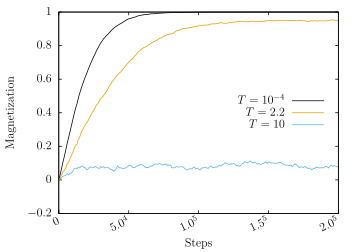

In [5]:
const seed = 150;

gp = Gnuplot("thermalization.svg")
write(gp.f, "set xlabel 'Steps'; set ylabel 'Magnetization';
    set key center right; set format x '\$%1.1t^%T\$'; set xtics add ('0' 0) rotate by 25 right
    plot '-' w l t '\$T = 10^{-4}\$', '' w l t '\$T = 2.2\$', '' w l t '\$T = 10\$';\n")

# Thermalization for different temperatures.
n = 100; J = 1.0; h = 0.5;
steps = 200000
temperatures = (1e-4, 2.2, 10.0)
for T in temperatures
    l = squareLattice(n,J,h,seed)
    for i in 0:steps
        if mod(i,1000) == 0; write(gp.f, "$i $(l.M)\n"); end
        monteCarlo!(l,T,J,h)
    end
    write(gp.f,"e\n\n")
end
plot(gp)

## $M(T),\, C_V(T),\, \chi(T)$

In [6]:
function measure(TRange)
    MM::Vector{Float64} = []
    CC::Vector{Float64} = []
    XX::Vector{Float64} = []
    for T in TRange
        # Let the system thermalize. Fewer steps are needed for thermalization since we
        # started from a previously thermalized system, and also because
        # small increments of temperature are taken.
        # The smaller the number of steps taken the more we leave
        # the system out of equilibrium. In that case hysteresis is expected.
        steps = 10000
        for i = 1:steps; monteCarlo!(l, T, J, h); end
        
        # Take the next N steps after thermalization.
        # and make some measurements:
        # average magnetization, specific heat, susceptibility.
        N = 10000
        M = 0; H = 0
        M2 = 0; H2 = 0
        for i = 1:N
            M += l.M
            H += l.H
            M2 += l.M*l.M
            H2 += l.H*l.H
            monteCarlo!(l, T, J, h)
        end
        # Mean
        M /= N
        H /= N
        # variance: mean of square minus square of mean
        M2 = M2/N - M*M
        H2 = H2/N - H*H
        T2 = T*T
        push!(MM, M)
        push!(CC, H2/T2)
        push!(XX, M2/T2)
    end
    return MM,CC,XX
end

measure (generic function with 1 method)

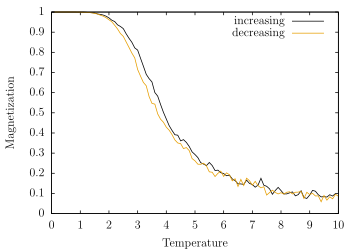

In [7]:
# Let's start a new nxn square lattice with a temperature of Ta and thermalize it.
# We know from the previous result that we need at least
# 100,000 steps to thermalize the system at this temperature Ta.
n = 100; J = 1.0; h = 0.5;
l = squareLattice(n, J, h, seed)
Ta = 1e-4
steps = 200000
for i in 1:steps; monteCarlo!(l,Ta,J,h); end

# We now, slowly, increase the temperature until we reach Tb = 10.
# In each new temperature we let the system thermalize and
# then we take measures.
dt = 1e-1
Tb = 10.0
TInc = collect(Ta:dt:Tb)

# The same process is repeated but from Tb to Ta, now with
# decreasing temperature.
dt *= -1
TDec = collect(Tb:dt:Ta)

MInc,CInc,XInc = measure(TInc)
MDec,CDec,XDec = measure(TDec)

# Plot of the average magnetization.
gp = Gnuplot("magnetization.svg")
write(gp.f,"set key top right; set xlabel 'Temperature'; set ylabel 'Magnetization';
        plot '-' u 1:2 w l t 'increasing', '' u 1:2 w l t 'decreasing';\n")
for i in eachindex(TInc)
    write(gp.f,"$(TInc[i]) $(MInc[i])\n")
end
write(gp.f, "e\n")
for i in eachindex(TDec)
    write(gp.f,"$(TDec[i]) $(MDec[i])\n")
end
plot(gp)

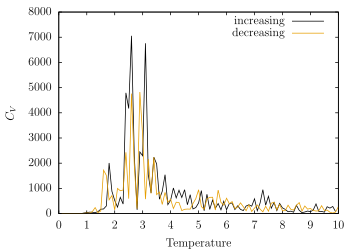

In [8]:
# Plot of the specific heat
gp = Gnuplot("specificHeat.svg")
write(gp.f,"set key top right; set xlabel 'Temperature'; set ylabel '\$C_V\$';
        plot '-' u 1:2 w l t 'increasing', '' u 1:2 w l t 'decreasing';\n")
for i in eachindex(TInc)
    write(gp.f,"$(TInc[i]) $(CInc[i])\n")
end
write(gp.f, "e\n")
for i in eachindex(TDec)
    write(gp.f,"$(TDec[i]) $(CDec[i])\n")
end
plot(gp)


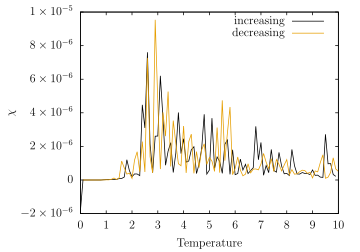

In [9]:
# Plot of the magnetic susceptibility
gp = Gnuplot("susceptibility.svg")
write(gp.f,"set key top right; set xlabel 'Temperature'; set ylabel '\$\\chi\$';
        plot '-' u 1:2 w l t 'increasing', '' u 1:2 w l t 'decreasing';\n")
for i in eachindex(TInc)
    write(gp.f,"$(TInc[i]) $(XInc[i])\n")
end
write(gp.f, "e\n")
for i in eachindex(TDec)
    write(gp.f,"$(TDec[i]) $(XDec[i])\n")
end
plot(gp)

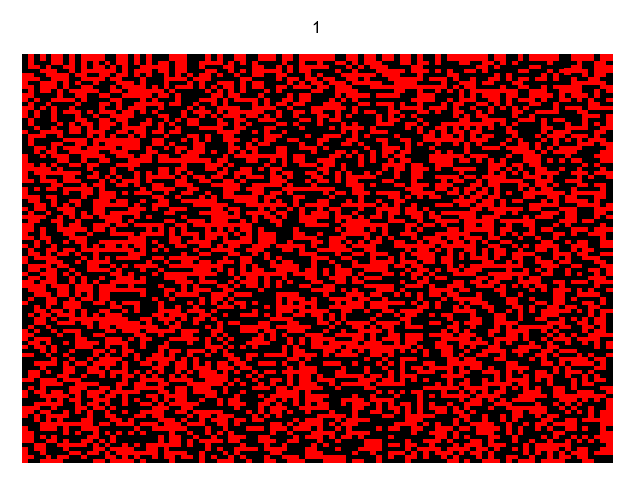

20 frames in animation sequence


In [10]:
n = 100; J = -1.0; h = 0.5; T=2.2
l = squareLattice(n, J, h, 150)

frames = 20;
gp = Gnuplot("lattice.gif")
write(gp.f, "set notics; set noborder; unset colorbox;
            set palette defined (-1 'black', 1 'red');")
for i in 1:frames
    k = 1
    write(gp.f, "set title '$i';plot '-' u 1:2:3 w p pt 5 lc palette\n")
    for y in 1:n, x in 1:n
        write(gp.f, "$x $y $(l.spins[k])\n")
        k += 1
    end
    write(gp.f, "e\n")
    for i in 1:5000; monteCarlo!(l,Ta,J,h); end
end
plot(gp)

![](./lattice.gif)
